In [1]:
#Import packages
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
import torch.optim as optim
from torchvision import models
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import cv2
from PIL import Image
import dlib


In [2]:
#Metrics calculation Function
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

***Evaluating models without facial landmarks***

In [3]:
#Custom Model:EmotionClassifier
transform  = transforms.Compose([
    transforms.Resize((48,48)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//train',transform= transform)
test_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//test',transform= transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

#Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*1*1,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = self.conv3(X)
        X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    


# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
  

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)


Epoch: 1/5 Loss: 1.786285332953744
Epoch: 1/5 Accuracy: 0.26364554669267476
Epoch: 2/5 Loss: 1.496244578491606
Epoch: 2/5 Accuracy: 0.4148873175659201
Epoch: 3/5 Loss: 1.3150772025563935
Epoch: 3/5 Accuracy: 0.4924936431084329
Epoch: 4/5 Loss: 1.232542761981089
Epoch: 4/5 Accuracy: 0.5282663972970149
Epoch: 5/5 Loss: 1.1671662324653702
Epoch: 5/5 Accuracy: 0.5566198753004284
*******Train**********
Accuracy score : 0.5566198753004284
Precision : 0.513464447777855
Recall : 0.47028281485820916
F1 score: 0.47170729424017793
*******Test**********
Accuracy score : 0.5351072722206743
Precision : 0.5275499080699518
Recall : 0.45569405182347245
F1 score: 0.46146266114609974


In [4]:
#LeNet5
transform  = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//train',transform= transform)
test_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//test',transform= transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels= 6,kernel_size= 5)
        self.pool = nn.AvgPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels= 16,kernel_size= 5)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels= 120,kernel_size= 5)
        self.fc1=nn.Linear(120,84)
        self.fc2=nn.Linear(84,7)
    def forward(self,X):
        X=torch.tanh(self.conv1(X))
        X=self.pool(X)
        X=torch.tanh(self.conv2(X))
        X=self.pool(X)
        X=torch.tanh(self.conv3(X))
        X = X.view(-1, 120)
        X=torch.tanh(self.fc1(X))
        X=self.fc2(X)
        return X

model=LeNet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

n_epoch=5

#Train the model
for epoch in range(1,n_epoch+1):
    running_loss = 0.0
    correct=0
    total=0
    train_true = []
    train_pred = []
    for images, labels in train_loader:
        # Train the model
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        total=total+labels.size(0)
        _,predictions=torch.max(outputs,1)
        correct=correct+ (predictions==labels).sum().item()
        train_true.extend(labels)
        train_pred.extend(predictions)
    print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
    print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)

#Evaluate the model
model.eval()
test_true = []
test_pred = []  
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _,predictions=torch.max(outputs,1)
        test_true.extend(labels)
        test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.7175785937659724
Epoch: 1/5 Accuracy: 0.31268940053641714
Epoch: 2/5 Loss: 1.6306326252580485
Epoch: 2/5 Accuracy: 0.3638231913337281
Epoch: 3/5 Loss: 1.5927322581244472
Epoch: 3/5 Accuracy: 0.38078651294019294
Epoch: 4/5 Loss: 1.5502343615869636
Epoch: 4/5 Accuracy: 0.3979936605245742
Epoch: 5/5 Loss: 1.5003145642429259
Epoch: 5/5 Accuracy: 0.4199379985370441
*******Train**********
Accuracy score : 0.4199379985370441
Precision : 0.39640880018709185
Recall : 0.33793801021291714
F1 score: 0.32902585995181965
*******Test**********
Accuracy score : 0.41083867372527166


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.3224850276736119
Recall : 0.3298032411184854
F1 score: 0.31660582691150657


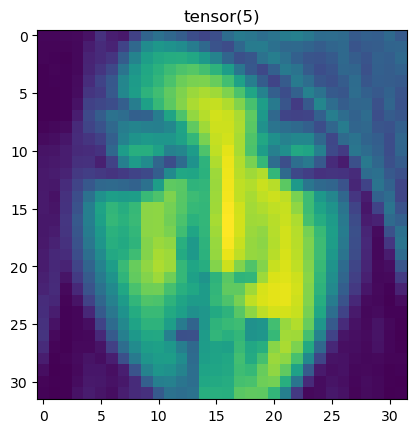

In [5]:
import numpy as np
import matplotlib.pyplot as plt
imgs,labels=next(iter(train_loader))
img=imgs[4]
img=np.transpose(img,(1,2,0))
plt.imshow(img)
plt.title(labels[4])
plt.show()

In [7]:
#AlexNet

transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//train',transform= transform)
test_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//test',transform= transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Load a pre-trained AlexNet model
model = models.alexnet(pretrained=True)
for par in model.parameters():
    par.requires_grad=False

# Modify the last fully connected layer to fit the number of classes (10 for MNIST)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 7) 

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epoch=5

#Train the model
for epoch in range(1,n_epoch+1):
    running_loss = 0.0
    correct=0
    total=0
    train_true = []
    train_pred = []
    for images, labels in train_loader:
        # Train the model
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        total=total+labels.size(0)
        _,predictions=torch.max(outputs,1)
        correct=correct+ (predictions==labels).sum().item()
        train_true.extend(labels)
        train_pred.extend(predictions)
    print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
    print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)

#Evaluate the model
model.eval()
test_true = []
test_pred = []  
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _,predictions=torch.max(outputs,1)
        test_true.extend(labels)
        test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

C:\Users\USER\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:11<00:00, 20.5MB/s] 


Epoch: 1/5 Loss: 1.819569539386605
Epoch: 1/5 Accuracy: 0.24995645964680066
Epoch: 2/5 Loss: 1.814147062715815
Epoch: 2/5 Accuracy: 0.2513149186666202
Epoch: 3/5 Loss: 1.8133858091847137
Epoch: 3/5 Accuracy: 0.2513149186666202
Epoch: 4/5 Loss: 1.812250180738275
Epoch: 4/5 Accuracy: 0.2513149186666202
Epoch: 5/5 Loss: 1.8119299743648096
Epoch: 5/5 Accuracy: 0.2513149186666202
*******Train**********
Accuracy score : 0.2513149186666202


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.0359021312380886
Recall : 0.14285714285714285
F1 score: 0.057383046749487014
*******Test**********
Accuracy score : 0.24714405126776262


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.0353062930382518
Recall : 0.14285714285714285
F1 score: 0.0566194306140687


In [8]:
#ResNet18

model=models.resnet18(pretrained=True)
for par in model.parameters():
    par.requires_grad=False

model.fc=nn.Linear(model.fc.in_features,7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)


n_epoch=5

#Train the model
for epoch in range(1,n_epoch+1):
    running_loss = 0.0
    correct=0
    total=0
    train_true = []
    train_pred = []
    for images, labels in train_loader:
        # Train the model
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        total=total+labels.size(0)
        _,predictions=torch.max(outputs,1)
        correct=correct+ (predictions==labels).sum().item()
        train_true.extend(labels)
        train_pred.extend(predictions)
    print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
    print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)

#Evaluate the model
model.eval()
test_true = []
test_pred = []  
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _,predictions=torch.max(outputs,1)
        test_true.extend(labels)
        test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)


C:\Users\USER\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\USER/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 37.5MB/s]


Epoch: 1/5 Loss: 1.6025783715641047
Epoch: 1/5 Accuracy: 0.3719739454526455
Epoch: 2/5 Loss: 1.509666473868164
Epoch: 2/5 Accuracy: 0.4188233654951409
Epoch: 3/5 Loss: 1.483025113166308
Epoch: 3/5 Accuracy: 0.42955170852345953
Epoch: 4/5 Loss: 1.477052818162404
Epoch: 4/5 Accuracy: 0.434776550907381
Epoch: 5/5 Loss: 1.466651826101316
Epoch: 5/5 Accuracy: 0.4389912570970776
*******Train**********
Accuracy score : 0.4389912570970776
Precision : 0.43103645583647593
Recall : 0.3705102442508971
F1 score: 0.3730503477496483
*******Test**********
Accuracy score : 0.4210086375034829
Precision : 0.4209445948541482
Recall : 0.36252754487110384
F1 score: 0.33802640365436615


***With facial landmarks***

In [ ]:
#Load Dlib's face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('D://ranjiny//Guvi_python//Finalproject//shape_predictor_68_face_landmarks.dat')

In [40]:
#Define a function to concatenate the image and heatmap
def extract_landmarks(img):
    image_np = np.array(img)
    faces = detector(image_np)
    if len(faces) == 0:  # Check if any faces are detected
        return img
    for face in faces:
        landmarks = predictor(image_np, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image_np, (x, y), 2, (0, 255, 0), -1)
    #image_np=cv2.resize(image_np,(48,48))
    return Image.fromarray(image_np)

#Load FER-2013 dataset
transform = transforms.Compose([transforms.Resize((96,96)),
                                transforms.Lambda(lambda img: extract_landmarks(img)),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//train',transform= transform)
test_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//test',transform= transform)

#Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

#Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*4*4,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = self.conv3(X)
        X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
   

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.743281495199437
Epoch: 1/5 Accuracy: 0.29293949632519417
Epoch: 2/5 Loss: 1.4769312870130773
Epoch: 2/5 Accuracy: 0.42892472743738896
Epoch: 3/5 Loss: 1.378236718459225
Epoch: 3/5 Accuracy: 0.47079313107387927
Epoch: 4/5 Loss: 1.3120134279032327
Epoch: 4/5 Accuracy: 0.49615103277717787
Epoch: 5/5 Loss: 1.2563038874575183
Epoch: 5/5 Accuracy: 0.5221010832839876
*******Train**********
Accuracy score : 0.5221010832839876
Precision : 0.4890585670627235
Recall : 0.44491538278910936
F1 score: 0.4493018048294908
*******Test**********
Accuracy score : 0.5101699637782112
Precision : 0.4932709594263393
Recall : 0.44533092489457166
F1 score: 0.44081277336177543


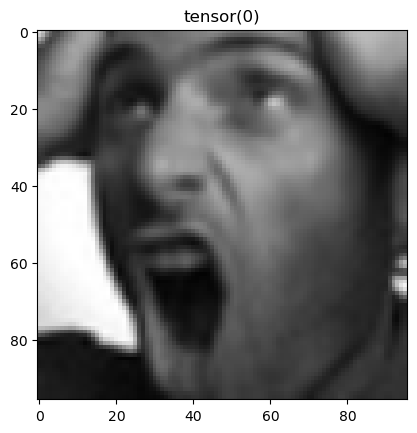

(96, 96, 3)


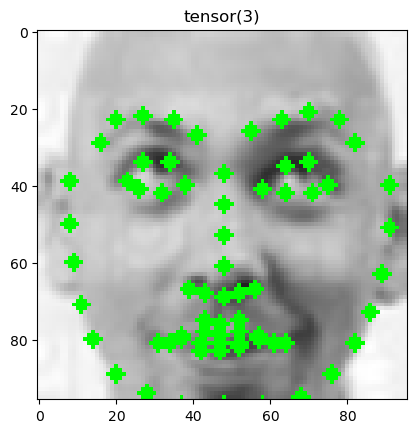

(96, 96, 3)


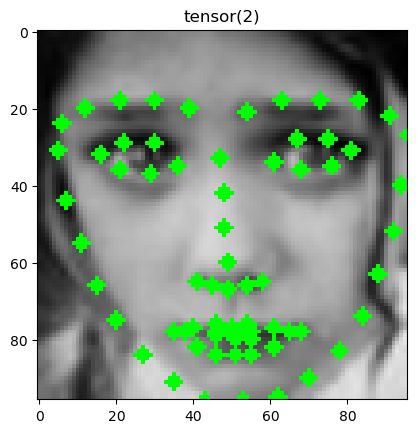

(96, 96, 3)


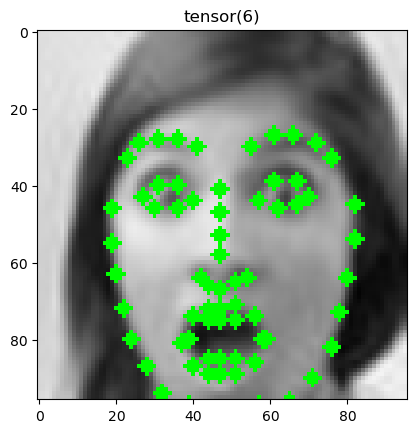

(96, 96, 3)


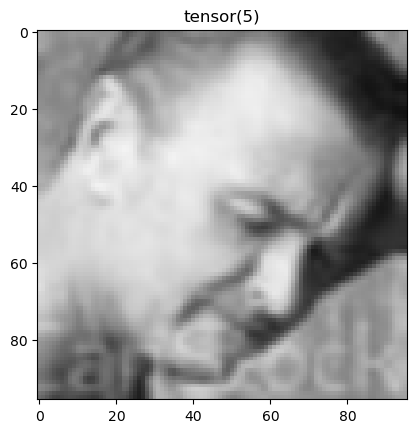

(96, 96, 3)


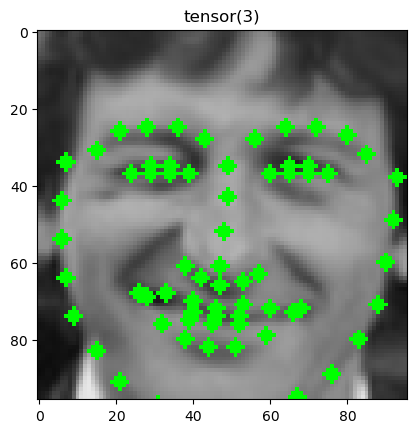

(96, 96, 3)


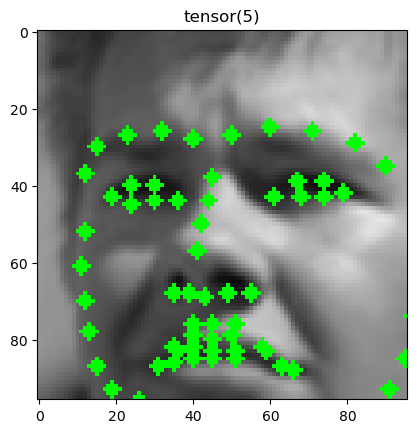

(96, 96, 3)


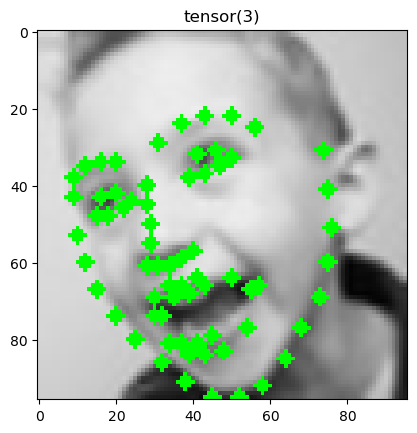

(96, 96, 3)


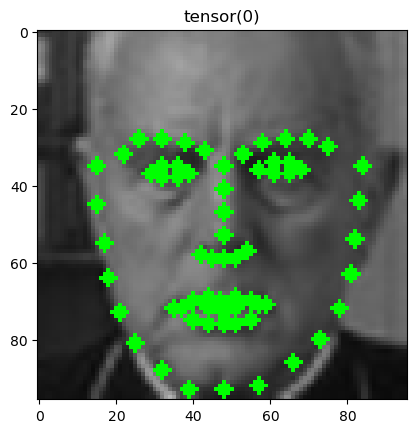

(96, 96, 3)


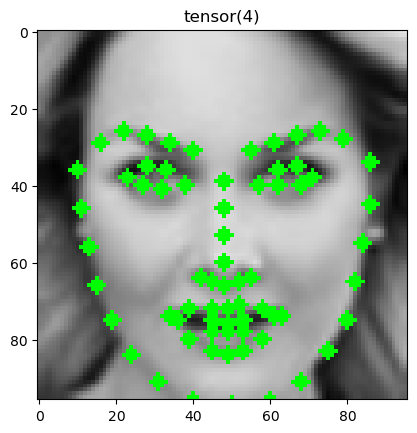

(96, 96, 3)


In [39]:
import numpy as np
import matplotlib.pyplot as plt
imgs,labels=next(iter(train_loader))
for i in range(10):
    img=imgs[i].numpy()
    img=np.transpose(img,(1,2,0))
    plt.imshow(img)
    plt.title(labels[i])
    plt.show()
    print(img.shape)


In [41]:
#LeNet

#Define a function to concatenate the image and heatmap
def extract_landmarks1(img):
    image=img
    image_np=image.resize((96,96))
    image_np = np.array(img)
    faces = detector(image_np)
    if len(faces) == 0:  # Check if any faces are detected
        return image
    for face in faces:
        landmarks = predictor(image_np, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image_np, (x, y), 2, (0, 255, 0), -1)
    image_np=cv2.resize(image_np,(32,32))
    return Image.fromarray(image_np)

#Load FER-2013 dataset
transform = transforms.Compose([transforms.Resize((32,32)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.Lambda(lambda img: extract_landmarks1(img)),
                                transforms.ToTensor()])

train_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//train',transform= transform)
test_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//test',transform= transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels= 6,kernel_size= 5)
        self.pool = nn.AvgPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels= 16,kernel_size= 5)
        self.conv3 = nn.Conv2d(in_channels=16,out_channels= 120,kernel_size= 5)
        self.fc1=nn.Linear(120,84)
        self.fc2=nn.Linear(84,7)
    def forward(self,X):
        X=torch.tanh(self.conv1(X))
        X=self.pool(X)
        X=torch.tanh(self.conv2(X))
        X=self.pool(X)
        X=torch.tanh(self.conv3(X))
        X = X.view(-1, 120)
        X=torch.tanh(self.fc1(X))
        X=self.fc2(X)
        return X

model=LeNet()
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

n_epoch=5

#Train the model
for epoch in range(1,n_epoch+1):
    running_loss = 0.0
    correct=0
    total=0
    train_true = []
    train_pred = []
    for images, labels in train_loader:
        # Train the model
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        total=total+labels.size(0)
        _,predictions=torch.max(outputs,1)
        correct=correct+ (predictions==labels).sum().item()
        train_true.extend(labels)
        train_pred.extend(predictions)
    print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
    print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)

#Evaluate the model
model.eval()
test_true = []
test_pred = []  
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _,predictions=torch.max(outputs,1)
        test_true.extend(labels)
        test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.7047811520922689
Epoch: 1/5 Accuracy: 0.32185029084955935
Epoch: 2/5 Loss: 1.6370456987340625
Epoch: 2/5 Accuracy: 0.3591904977533178
Epoch: 3/5 Loss: 1.60271863337349
Epoch: 3/5 Accuracy: 0.3721132745828834
Epoch: 4/5 Loss: 1.5690324029041027
Epoch: 4/5 Accuracy: 0.38841478282071823
Epoch: 5/5 Loss: 1.5230077365724441
Epoch: 5/5 Accuracy: 0.4088961649656902
*******Train**********
Accuracy score : 0.4088961649656902
Precision : 0.4497167397038141
Recall : 0.3283923955052657
F1 score: 0.32018965459791815
*******Test**********
Accuracy score : 0.3921705210365004


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.3181445126953924
Recall : 0.3354178266215252
F1 score: 0.32019570094764704


In [4]:
#AlexNet

#Define a function to concatenate the image and heatmap
def extract_landmarks(img):
    image_np = np.array(img)
    faces = detector(image_np)
    if len(faces) == 0:  # Check if any faces are detected
        return img
    for face in faces:
        landmarks = predictor(image_np, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image_np, (x, y), 2, (0, 255, 0), -1)
    return Image.fromarray(image_np)

transform  = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.Lambda(lambda img: extract_landmarks(img)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//train',transform= transform)
test_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//test',transform= transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

# Load a pre-trained AlexNet model
model = models.alexnet(pretrained=True)
for par in model.parameters():
    par.requires_grad=False

# Modify the last fully connected layer to fit the number of classes (10 for MNIST)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 7) 

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epoch=5

#Train the model
for epoch in range(1,n_epoch+1):
    running_loss = 0.0
    correct=0
    total=0
    train_true = []
    train_pred = []
    for images, labels in train_loader:
        # Train the model
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        total=total+labels.size(0)
        _,predictions=torch.max(outputs,1)
        correct=correct+ (predictions==labels).sum().item()
        train_true.extend(labels)
        train_pred.extend(predictions)
    print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
    print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)

#Evaluate the model
model.eval()
test_true = []
test_pred = []  
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _,predictions=torch.max(outputs,1)
        test_true.extend(labels)
        test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)



Epoch: 1/5 Loss: 1.733177489188307
Epoch: 1/5 Accuracy: 0.33268313072555644
Epoch: 2/5 Loss: 1.6758469075030897
Epoch: 2/5 Accuracy: 0.3613500992720053
Epoch: 3/5 Loss: 1.6764561580390336
Epoch: 3/5 Accuracy: 0.36511198578842874
Epoch: 4/5 Loss: 1.674025846085198
Epoch: 4/5 Accuracy: 0.36866487860949526
Epoch: 5/5 Loss: 1.6545483990342156
Epoch: 5/5 Accuracy: 0.37347173360270297
*******Train**********
Accuracy score : 0.37347173360270297
Precision : 0.3303206570446823
Recall : 0.3157385728670765
F1 score: 0.31719534732534477
*******Test**********
Accuracy score : 0.4197548063527445
Precision : 0.42654661071716926
Recall : 0.3632263000853471
F1 score: 0.3500067350090822


In [5]:
#ResNet18
model=models.resnet18(pretrained=True)
for par in model.parameters():
    par.requires_grad=False

model.fc=nn.Linear(model.fc.in_features,7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)


n_epoch=5

#Train the model
for epoch in range(1,n_epoch+1):
    running_loss = 0.0
    correct=0
    total=0
    train_true = []
    train_pred = []
    for images, labels in train_loader:
        # Train the model
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        total=total+labels.size(0)
        _,predictions=torch.max(outputs,1)
        correct=correct+ (predictions==labels).sum().item()
        train_true.extend(labels)
        train_pred.extend(predictions)
    print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
    print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)

#Evaluate the model
model.eval()
test_true = []
test_pred = []  
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _,predictions=torch.max(outputs,1)
        test_true.extend(labels)
        test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

C:\Users\USER\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 1/5 Loss: 1.6158652887047
Epoch: 1/5 Accuracy: 0.3702323313246717
Epoch: 2/5 Loss: 1.5209612834427033
Epoch: 2/5 Accuracy: 0.4169075899543697
Epoch: 3/5 Loss: 1.4934173181221586
Epoch: 3/5 Accuracy: 0.42558082831167926
Epoch: 4/5 Loss: 1.4785637168549748
Epoch: 4/5 Accuracy: 0.435438364276011
Epoch: 5/5 Loss: 1.4720991997251531
Epoch: 5/5 Accuracy: 0.4319899683026229
*******Train**********
Accuracy score : 0.4319899683026229
Precision : 0.4045164001337909
Recall : 0.36330065915867876
F1 score: 0.36508190636126436
*******Test**********
Accuracy score : 0.4254667038172193
Precision : 0.4326521068396419
Recall : 0.3658807807641145
F1 score: 0.36819386856372727


***Optimizing Emotion Classifier***

In [9]:
#Define a function to concatenate the image and heatmap
def extract_landmarks(img):
    #image=img
    image_np=img.resize((128,128))
    image_np = np.array(image_np)
    faces = detector(image_np)
    if len(faces) == 0:  # Check if any faces are detected
        return img
    for face in faces:
        landmarks = predictor(image_np, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image_np, (x, y), 2, (0, 255, 0), -1)
    image_np=cv2.resize(image_np,(48,48))
    return Image.fromarray(image_np)

#Load FER-2013 dataset
transform = transforms.Compose([transforms.Resize((48,48)),
                                transforms.Lambda(lambda img: extract_landmarks(img)),
                                transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//train',transform= transform)
test_dataset = datasets.ImageFolder(root='D://ranjiny//Guvi_python//Finalproject//Datasets//test',transform= transform)

#Data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*1*1,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = self.conv3(X)
        X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
   

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.5916372051748773
Epoch: 1/5 Accuracy: 0.36465916611515553
Epoch: 2/5 Loss: 1.329014039982135
Epoch: 2/5 Accuracy: 0.4911003518060538
Epoch: 3/5 Loss: 1.2210832152573727
Epoch: 3/5 Accuracy: 0.5373576230450381
Epoch: 4/5 Loss: 1.13574377916969
Epoch: 4/5 Accuracy: 0.5708662788672542
Epoch: 5/5 Loss: 1.059494607299898
Epoch: 5/5 Accuracy: 0.6006478804556062
*******Train**********
Accuracy score : 0.6006478804556062
Precision : 0.568781534836548
Recall : 0.5282618945130407
F1 score: 0.5381434297780456
*******Test**********
Accuracy score : 0.5572582892170521
Precision : 0.5597644109451009
Recall : 0.5029124983240104
F1 score: 0.5116266177665098


In [10]:
#With softmax
#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*1*1,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = self.conv3(X)
        X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        X=torch.softmax(X,dim=1)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
  

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.8391411990790165
Epoch: 1/5 Accuracy: 0.30965899195374275
Epoch: 2/5 Loss: 1.7942883207697113
Epoch: 2/5 Accuracy: 0.3579713678637361
Epoch: 3/5 Loss: 1.755532118419231
Epoch: 3/5 Accuracy: 0.399003796718799
Epoch: 4/5 Loss: 1.7373576707192147
Epoch: 4/5 Accuracy: 0.4174997387578808
Epoch: 5/5 Loss: 1.7252233929782774
Epoch: 5/5 Accuracy: 0.43167647775958756
*******Train**********
Accuracy score : 0.43167647775958756
Precision : 0.3262501312809702
Recall : 0.34490630930834965
F1 score: 0.31763472014774685
*******Test**********
Accuracy score : 0.4484536082474227


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.3483321351807548
Recall : 0.3580601256485538
F1 score: 0.31136647792504535


In [12]:
#With softmax and without multiple maxpool
#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*3*3,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = self.conv3(X)
        #X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        X=torch.softmax(X,dim=1)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.9144944373377182
Epoch: 1/5 Accuracy: 0.2512452541015013
Epoch: 2/5 Loss: 1.9141554974500745
Epoch: 2/5 Accuracy: 0.2513149186666202
Epoch: 3/5 Loss: 1.9143434149650795
Epoch: 3/5 Accuracy: 0.2513149186666202
Epoch: 4/5 Loss: 1.9141554974500745
Epoch: 4/5 Accuracy: 0.2513149186666202
Epoch: 5/5 Loss: 1.91396757980232
Epoch: 5/5 Accuracy: 0.2513149186666202
*******Train**********
Accuracy score : 0.2513149186666202


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.0359021312380886
Recall : 0.14285714285714285
F1 score: 0.057383046749487014
*******Test**********
Accuracy score : 0.24714405126776262


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.0353062930382518
Recall : 0.14285714285714285
F1 score: 0.0566194306140687


In [13]:
#Without softmax and without multiple maxpool
#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*3*3,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = self.conv3(X)
        #X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
   

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.6214589123471013
Epoch: 1/5 Accuracy: 0.353791493956599
Epoch: 2/5 Loss: 1.434076591562853
Epoch: 2/5 Accuracy: 0.4462363718694486
Epoch: 3/5 Loss: 1.352704509462174
Epoch: 3/5 Accuracy: 0.4796753631265457
Epoch: 4/5 Loss: 1.3015519752932552
Epoch: 4/5 Accuracy: 0.5016197011390157
Epoch: 5/5 Loss: 1.2579205941516731
Epoch: 5/5 Accuracy: 0.5197324880699432
*******Train**********
Accuracy score : 0.5197324880699432
Precision : 0.4731464101507913
Recall : 0.44164978974547126
F1 score: 0.4444093775649133
*******Test**********
Accuracy score : 0.4860685427695737
Precision : 0.5049156062017144
Recall : 0.4210550573842138
F1 score: 0.4385218540582358


In [14]:
#Without softmax and without multiple maxpool
#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*3*3,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = torch.relu(self.conv3(X))
        #X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
   

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.5917684291147176
Epoch: 1/5 Accuracy: 0.36211640948831375
Epoch: 2/5 Loss: 1.350684321670065
Epoch: 2/5 Accuracy: 0.4842732244243965
Epoch: 3/5 Loss: 1.2477215499283212
Epoch: 3/5 Accuracy: 0.5269776028423142
Epoch: 4/5 Loss: 1.168026521237762
Epoch: 4/5 Accuracy: 0.5595109547528649
Epoch: 5/5 Loss: 1.0860421158423137
Epoch: 5/5 Accuracy: 0.5925667909018077
*******Train**********
Accuracy score : 0.5925667909018077
Precision : 0.5682007916967299
Recall : 0.5264461322017099
F1 score: 0.5372851072141918
*******Test**********
Accuracy score : 0.5544719977709669
Precision : 0.5514955285532885
Recall : 0.4980943595919426
F1 score: 0.5095948553805186


In [15]:
#Without softmax and without multiple maxpool
#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*3*3,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = torch.relu(self.conv3(X))
        #X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
   

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.609000152429122
Epoch: 1/5 Accuracy: 0.35880734264516356
Epoch: 2/5 Loss: 1.3581093233783952
Epoch: 2/5 Accuracy: 0.479187711170713
Epoch: 3/5 Loss: 1.25506801382205
Epoch: 3/5 Accuracy: 0.5227628966526177
Epoch: 4/5 Loss: 1.1772830429878958
Epoch: 4/5 Accuracy: 0.5547389320422167
Epoch: 5/5 Loss: 1.1023963204603684
Epoch: 5/5 Accuracy: 0.5838935525444983
*******Train**********
Accuracy score : 0.5838935525444983
Precision : 0.5642384061280579
Recall : 0.5232124910035975
F1 score: 0.5340730201843812
*******Test**********
Accuracy score : 0.5369183616606297
Precision : 0.550189485874679
Recall : 0.46699775071151556
F1 score: 0.47883414657447665


In [16]:

#Without softmax and without multiple maxpool
#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*3*3,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = torch.relu(self.conv3(X))
        #X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
   

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.816383391950603
Epoch: 1/5 Accuracy: 0.246542895955972
Epoch: 2/5 Loss: 1.794199981243414
Epoch: 2/5 Accuracy: 0.25274304225155875
Epoch: 3/5 Loss: 1.7839574909422604
Epoch: 3/5 Accuracy: 0.2575847295273259
Epoch: 4/5 Loss: 1.7299317311337903
Epoch: 4/5 Accuracy: 0.2962485631683444
Epoch: 5/5 Loss: 1.6213805331684699
Epoch: 5/5 Accuracy: 0.35835452297189035
*******Train**********
Accuracy score : 0.35835452297189035


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.2671970187066734
Recall : 0.27855538041013234
F1 score: 0.2553895867090117
*******Test**********
Accuracy score : 0.37405962663694625


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision : 0.28612248261650924
Recall : 0.2912021305964738
F1 score: 0.26811180656058436


In [17]:
#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*1*1,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = self.conv3(X)
        X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
   

n_epoch=20
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/20 Loss: 1.5823272107571429
Epoch: 1/20 Accuracy: 0.36866487860949526
Epoch: 2/20 Loss: 1.3018223827161344
Epoch: 2/20 Accuracy: 0.5006095649447908
Epoch: 3/20 Loss: 1.1925592139064602
Epoch: 3/20 Accuracy: 0.5471106621616915
Epoch: 4/20 Loss: 1.1094301223489382
Epoch: 4/20 Accuracy: 0.5806193179839075
Epoch: 5/20 Loss: 1.0285814829950608
Epoch: 5/20 Accuracy: 0.6106447455501759
Epoch: 6/20 Loss: 0.9472649949032373
Epoch: 6/20 Accuracy: 0.645477028109652
Epoch: 7/20 Loss: 0.8604721168101763
Epoch: 7/20 Accuracy: 0.6776272249120485
Epoch: 8/20 Loss: 0.7781316934688585
Epoch: 8/20 Accuracy: 0.7119021909505729
Epoch: 9/20 Loss: 0.700363672124782
Epoch: 9/20 Accuracy: 0.7430770838413041
Epoch: 10/20 Loss: 0.6138697460891144
Epoch: 10/20 Accuracy: 0.7735901633634052
Epoch: 11/20 Loss: 0.5529316432259661
Epoch: 11/20 Accuracy: 0.7942108746386151
Epoch: 12/20 Loss: 0.4899581954015921
Epoch: 12/20 Accuracy: 0.8224250235117907
Epoch: 13/20 Loss: 0.4268032602617364
Epoch: 13/20 Accuracy

***Training and saving the selected model***

In [18]:
#Step 3: Emotion Classification
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=0)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=0)
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2,padding=0)
        self.dropout=nn.Dropout(0.5)
        self.fc1 = nn.Linear(128*1*1,256)
        self.fc2 = nn.Linear(256,7)

    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = torch.relu(self.pool(X))
        X = self.conv3(X)
        X = torch.relu(self.pool(X))
        X = self.conv4(X)
        X = torch.relu(self.pool(X))
        X = self.conv5(X)
        X = torch.relu(self.pool(X))
        X = torch.flatten(X,1)
        X = self.fc1(X)
        X= self.dropout(X)
        X = self.fc2(X)
        return X
    
def calculate_metrics(y_true, y_pred):
    print(f'Accuracy score : {accuracy_score(y_true, y_pred)}')
    print(f'Precision : {precision_score(y_true, y_pred, average='macro')}')
    print(f'Recall : {recall_score(y_true, y_pred, average='macro')}')
    print(f'F1 score: {f1_score(y_true, y_pred, average='macro')}')
    return 

# #Train the model
model = EmotionClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=0.01)
   

n_epoch=5
for epoch in range(1,n_epoch+1):
  running_loss = 0.0
  correct=0
  total=0
  train_true = []
  train_pred = []
  for inputs,labels in train_loader:
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs,labels)
    loss.backward()
    optimizer.step()
    running_loss+=loss.item()
    total=total+labels.size(0)
    _,predictions=torch.max(outputs,1)
    correct=correct+ (predictions==labels).sum().item()
    train_true.extend(labels)
    train_pred.extend(predictions)
  print(f"Epoch: {epoch}/{n_epoch} Loss: {running_loss/len(train_loader)}")
  print(f"Epoch: {epoch}/{n_epoch} Accuracy: {correct/total}")
print('*******Train**********')
calculate_metrics(train_true, train_pred)


# Evaluation loop
model.eval()  # Set the model to evaluation mode

test_true = []
test_pred = []

with torch.no_grad():
  for images,labels in test_loader:
    outputs = model(images)
    _,predictions=torch.max(outputs,1)
    test_true.extend(labels)
    test_pred.extend(predictions)
print('*******Test**********')
calculate_metrics(test_true, test_pred)

Epoch: 1/5 Loss: 1.6072030858632451
Epoch: 1/5 Accuracy: 0.3570657285171897
Epoch: 2/5 Loss: 1.3432552177284767
Epoch: 2/5 Accuracy: 0.4826709394266606
Epoch: 3/5 Loss: 1.2208923044342772
Epoch: 3/5 Accuracy: 0.5325507680518304
Epoch: 4/5 Loss: 1.1326522836440922
Epoch: 4/5 Accuracy: 0.5688460064788046
Epoch: 5/5 Loss: 1.0522056829292152
Epoch: 5/5 Accuracy: 0.6012051969765578
*******Train**********
Accuracy score : 0.6012051969765578
Precision : 0.5745145726907006
Recall : 0.5299266282646566
F1 score: 0.5409284802019193
*******Test**********
Accuracy score : 0.5440234048481472
Precision : 0.5496377736381365
Recall : 0.47812715907392195
F1 score: 0.47751570854055786


In [21]:
#Saving the entire model
torch.save(model, 'model_complete.pth')

In [22]:
# Load the entire model (architecture + weights)
loaded_complete_model = torch.load('model_complete.pth')

# Set the model to evaluation mode (important for inference)
loaded_complete_model.eval()

C:\Users\USER\AppData\Local\Temp\ipykernel_5584\1661648377.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_complete_model = torch.load('model_complete.pth')


EmotionClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=128, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=7, bias=True)
)

In [33]:
from torchsummary import summary
#print(loaded_complete_model)

summary(loaded_complete_model,input_size=(3,48,48)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 46, 46]             896
            Conv2d-2           [-1, 64, 44, 44]          18,496
         MaxPool2d-3           [-1, 64, 22, 22]               0
            Conv2d-4          [-1, 128, 20, 20]          73,856
         MaxPool2d-5          [-1, 128, 10, 10]               0
            Conv2d-6            [-1, 128, 8, 8]         147,584
         MaxPool2d-7            [-1, 128, 4, 4]               0
            Conv2d-8            [-1, 128, 2, 2]         147,584
         MaxPool2d-9            [-1, 128, 1, 1]               0
           Linear-10                  [-1, 256]          33,024
          Dropout-11                  [-1, 256]               0
           Linear-12                    [-1, 7]           1,799
Total params: 423,239
Trainable params: 423,239
Non-trainable params: 0
-------------------------------